#### Location determination using radio signal strength indicator. 
##### This is more or less a mirror of https://www.kaggle.com/amirma/initial-analysis-of-the-rssi-samples

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sc
sns.set()
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]
from sklearn.model_selection import train_test_split

In [2]:
path = 'data/rssi/rssi.csv'
data = pd.read_csv(path)
coordinates = {"A": (23, 17, 2), "B": (23, 41, 2), "C" : (1, 15, 2), "D": (1, 41, 2)}

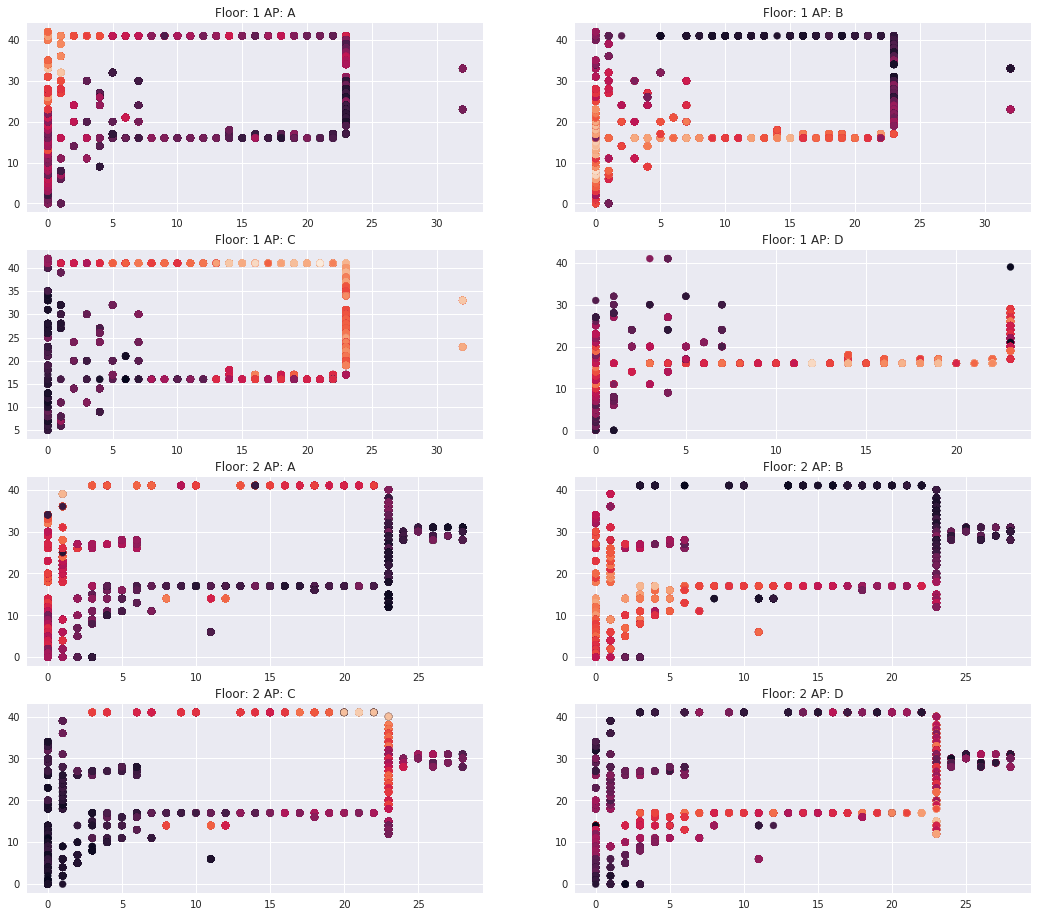

In [3]:
fig = plt.figure(figsize=(18, 16))
from itertools import product

axs = fig.subplots(4,2)
for pair, ax in zip(product((1,2), ("A","B","C","D")), axs.flatten()):
    (floor, ap) = pair
    mask = (data.z == floor) & (data.ap == ap)
    signal = data[mask][["signal", "x", "y"]]
    ax.scatter(signal.x, signal.y, c=signal.signal)
    ax.set_title("Floor: %s AP: %s" %(floor, ap))
    

In [8]:
# Create a new data frame that holds a summary of the data
stats = data.copy()
g = stats.groupby(["ap", "z", "x", "y"])
stats = g.agg({'signal': [np.min, np.max, np.mean, np.median, np.std], 'sequence' : [np.max]} )
stats = stats.reset_index()
stats["variability"] = stats.signal.amax - stats.signal.amin

#def dist(df):
#    # ap coordinates
#    x, y, z = coordinates[df.ap]
#    df["dist"] = np.sqrt((df.x - x) ** 2 + (df.y - y)  ** 2 + (df.z - z) ** 2)
#    return df
#stats = stats.groupby("ap").apply(dist)

In [162]:
stats.head()

ap    z    x    y signal                                   sequence  \
                      amin  amax       mean median       std     amax   
0  A  1.0  0.0  0.0    8.0  19.0  15.182432   15.0  2.119033    147.0   
1  A  1.0  0.0  1.0    9.0  16.0  12.793103   13.0  1.370319    202.0   
2  A  1.0  0.0  2.0    5.0  16.0  10.417969   11.0  2.062054    255.0   
3  A  1.0  0.0  3.0   10.0  19.0  14.995690   15.0  1.384821    231.0   
4  A  1.0  0.0  4.0   15.0  22.0  19.294393   20.0  1.195558    213.0   

  variability  
               
0        11.0  
1         7.0  
2        11.0  
3         9.0  
4         7.0

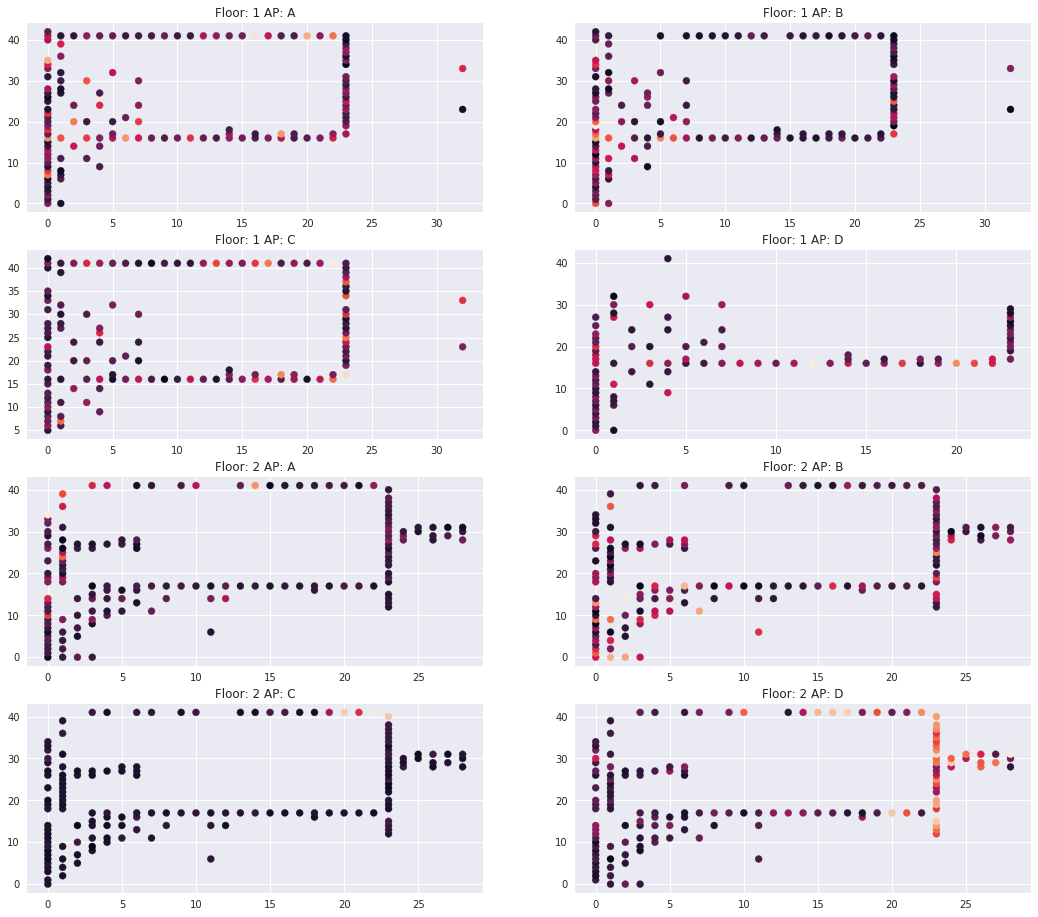

In [6]:
# Plot the variability of the signal 
fig = plt.figure(figsize=(18, 16))
axs = fig.subplots(4,2)
for pair, ax in zip(product((1,2), ("A","B","C","D")), axs.flatten()):
    (floor, ap) = pair
    mask = (stats.z == floor) & (stats.ap == ap)
    signal = stats[mask][["signal", "x", "y"]]
    ax.scatter(signal.x, signal.y, c=signal["signal", "std"])
    ax.set_title("Floor: %s AP: %s" %(floor, ap))
    

In [281]:
# Arrange the data in rows with signals from all APs
# TODO: Explain
g = data.groupby(["x", "y", "z"])
aps = set(("A", "B", "C", "D"))
def f(df):
    # Find the ap that has the largest number of samples
    ap = data.iloc[df.sequence.idxmax()].ap
    assert ap in aps
    base = df[df.ap == ap]
    for item in aps - set((ap,)):
        ss = df[df.ap == item].signal
        # stretch ss
        diff = len(base) - len(ss)
        assert diff >= 0
        if len(ss) == 0:
            ss = np.zeros(diff)
            base = base.assign(**{item:ss})
        elif diff > 0:
            ss = ss.append(ss.sample(n=diff, replace=True))
            ss.index = base.index
            base = base.assign(**{item:ss})
    base[ap] = base.signal
    base = base.drop(columns=["signal", "ap"])
    return base

extended_data = g.apply(f)


In [282]:
extended_data["encoded_coords"] = (extended_data.z * 10000) + (extended_data.y * 100) + extended_data.x

In [283]:
# Create a table of unique coordinates
data_coordinates = stats[["x", "y", "z"]]
g = data_coordinates.groupby(["x", "y", "z"])
unique_coordinates = g.agg(min)
unique_coordinates = unique_coordinates.sample(frac=1).reset_index(drop=True)

# Split the coordinates to two sets for training and test
train_coords, test_coords = train_test_split(unique_coordinates)

# Add missing columns to the sets 
test_coords.columns = ["x", "y", "z"]
train_coords.columns = ["x", "y", "z"]
training_set = pd.merge(train_coords, extended_data)
test_set = pd.merge(test_coords, extended_data)

X_train = training_set[["A", "B", "C", "D"]]
Y_train = training_set[["x", "y", "z"]]
#Y_train = training_set["encoded_coords"]

X_test = test_set[["A", "B", "C", "D"]]
Y_test = test_set[["x", "y", "z"]]
#Y_test = training_set["encoded_coords"]


/home/amir/.local/share/virtualenvs/pipenv-UfFdSzCR/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [284]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



In [285]:
onehot = OneHotEncoder()
onehot.fit(Y_train.append(Y_test))
Y_train_encoded = onehot.transform(Y_train)

print(Y_train.shape)
print(Y_train_encoded.shape)
print(Y_train_encoded[0])

(39982, 3)
(39982, 75)
  (0, 73)	1.0
  (0, 51)	1.0
  (0, 6)	1.0


In [297]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(4,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])
 
# 9. Fit model on training data
model.fit(X_train.values, Y_train, epochs=50, verbose=1)
 
# 10. Evaluate model on test data


Epoch 1/50
39982/39982 [==============================] - 1s 19us/step - loss: 35.3541 - acc: 0.8843
Epoch 2/50
39982/39982 [==============================] - 1s 19us/step - loss: 21.6841 - acc: 0.9018
Epoch 3/50
39982/39982 [==============================] - 1s 18us/step - loss: 18.9617 - acc: 0.9103
Epoch 4/50
39982/39982 [==============================] - 1s 18us/step - loss: 17.3367 - acc: 0.9131
Epoch 5/50
39982/39982 [==============================] - 1s 18us/step - loss: 16.3563 - acc: 0.9154
Epoch 6/50
39982/39982 [==============================] - 1s 18us/step - loss: 15.4987 - acc: 0.9171
Epoch 7/50
39982/39982 [==============================] - 1s 19us/step - loss: 14.8960 - acc: 0.9183
Epoch 8/50
39982/39982 [==============================] - 1s 19us/step - loss: 14.5248 - acc: 0.9200
Epoch 9/50
39982/39982 [==============================] - 1s 19us/step - loss: 14.2417 - acc: 0.9214
Epoch 10/50
39982/39982 [==============================] - 1s 19us/step - loss: 14.0221 - a

In [294]:
model.evaluate(X_test, Y_test)

12972/12972 [==============================] - 0s 5us/step


[19.00724570390217, 0.8966234967622572]

In [384]:
g = data.groupby(["ap", "z", "x", "y"])
mean_signal = g.agg({'signal': np.mean})
mean_signal = mean_signal.reset_index()

def ff(df):
    assert len(df) <= 4
    rec = df.iloc[0]
    a = df[df.ap == "A"]
    b = df[df.ap == "B"]
    c = df[df.ap == "C"]
    d = df[df.ap == "D"]
    res = pd.DataFrame({"x": rec.x, "y": rec.y, "z": rec.z, "A": a.signal, 
                        "B": b.signal, "C": c.signal, "D": d.signal})
    res = res.fillna(0)
    #res = res.agg({"A": np.max, "B": np.max, "C": np.max, "D": np.max})
    res = res.agg(np.max)
    return res
g = mean_signal.groupby(["z", "x", "y"])    
mean_signal = g.apply(ff)
mean_signal = mean_signal.set_index(np.arange(len(mean_signal)))



In [385]:
mean_signal.head()

,A,B,C,D,x,y,z
0,15.182432,31.117155,0.0,14.769231,0.0,0.0,1.0
1,12.793103,29.415663,0.0,13.387097,0.0,1.0,1.0
2,10.417969,25.404412,0.0,9.125000,0.0,2.0,1.0
3,14.995690,31.123894,0.0,12.963636,0.0,3.0,1.0
4,19.294393,30.466667,0.0,17.185185,0.0,4.0,1.0


In [386]:
training_set = pd.merge(train_coords, mean_signal)
test_set = pd.merge(test_coords, mean_signal)

X_train = training_set[["A", "B", "C", "D"]]
Y_train = training_set[["x", "y", "z"]]
#Y_train = training_set["encoded_coords"]

X_test = test_set[["A", "B", "C", "D"]]
Y_test = test_set[["x", "y", "z"]]


In [376]:
onehot = OneHotEncoder()
onehot.fit(Y_train.append(Y_test))
Y_train_encoded = onehot.transform(Y_train)
Y_test_encoded = onehot.transform(Y_test)
onehot.n_values_

array([33, 43,  3])

In [406]:
from keras import backend

def euclidean_distance(y1, y2):
    return backend.mean(backend.sqrt(((y1[0] - y2[0]) ** 2) + ((y1[1] - y2[1]) ** 2) + ((y1[2] - y2[2]) ** 2)), axis=-1)


model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(4,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='rmsprop',
              #loss=['mean_squared_error'],
              loss=euclidean_distance,
              #loss="cosine_proximity",
              #metrics=['accuracy'])
              metrics=[euclidean_distance, "accuracy"])
 
# 9. Fit model on training data
history = model.fit(X_train, Y_train, epochs=100, verbose=1)

# 10. Evaluate model on test data

Epoch 1/100
217/217 [==============================] - 0s 32us/step - loss: 23.8879 - euclidean_distance: 23.8879 - acc: 0.1613
Epoch 2/100
217/217 [==============================] - 0s 27us/step - loss: 21.7002 - euclidean_distance: 21.7002 - acc: 0.4194
Epoch 3/100
217/217 [==============================] - 0s 27us/step - loss: 18.5498 - euclidean_distance: 18.5498 - acc: 0.6037
Epoch 4/100
217/217 [==============================] - 0s 46us/step - loss: 15.5968 - euclidean_distance: 15.5968 - acc: 0.6313
Epoch 5/100
217/217 [==============================] - 0s 30us/step - loss: 15.4506 - euclidean_distance: 15.4506 - acc: 0.6636
Epoch 6/100
217/217 [==============================] - 0s 53us/step - loss: 12.1067 - euclidean_distance: 12.1067 - acc: 0.8433
Epoch 7/100
217/217 [==============================] - 0s 35us/step - loss: 9.3414 - euclidean_distance: 9.3414 - acc: 0.8571
Epoch 8/100
217/217 [==============================] - 0s 52us/step - loss: 8.6219 - euclidean_distance: 8

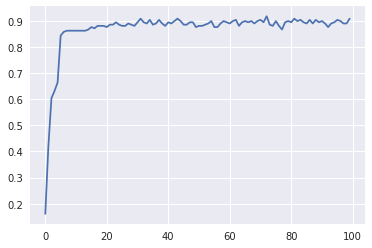

In [407]:
plt.plot(history.history['acc'])

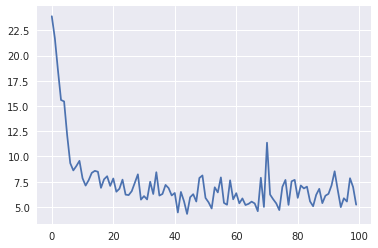

In [408]:
plt.plot(history.history['loss'])

In [410]:
model.evaluate(X_test, Y_test)

73/73 [==============================] - 0s 163us/step


[3.8608734542376375, 3.8608734542376375, 0.8904109597206116]

In [411]:
Y_pred = model.predict(X_test)

In [412]:
len(Y_test)

73

In [3]:
d = data.groupby(['x', 'y', 'z', 'ap']).signal.agg({'mean' : np.mean, 'min': np.min, 'max':np.max})

/home/amir/.local/share/virtualenvs/pipenv-UfFdSzCR/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [162]:
d = d.unstack()

In [163]:
d = d.fillna(0)

In [164]:
d = d.reset_index()

In [165]:
Y = d[['x', 'y', 'z']].get_values()

In [166]:
d.columns = d.columns.droplevel()

In [171]:
from sklearn.model_selection import train_test_split

In [180]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [183]:
from sklearn.preprocessing import OneHotEncoder

In [187]:
enc = OneHotEncoder()

In [194]:
enc.fit(Y)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [208]:
y_train_enc = enc.transform(y_train)

In [209]:
y_test_enc = enc.transform(y_test)

In [210]:
from sklearn.ensemble import RandomForestRegressor

In [211]:
rf = RandomForestRegressor()

In [237]:
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [241]:
y_pred = rf.predict(x_test)

In [257]:
Y_T = pd.DataFrame(y_train, columns=['x_t', 'y_t', 'z_t'])

In [258]:
Y_P = pd.DataFrame(y_pred, columns=['x_p', 'y_p', 'z_p'])

In [259]:
YY = pd.concat([Y_T, Y_P], axis=1)

In [17]:
d = d.reset_index()

In [24]:
d = d.pivot_table(index=['x', 'y', 'z'], columns='ap')

In [28]:
d = d.swaplevel(axis=1)

In [29]:
d = d.fillna(0)

In [31]:
d

ap                A     B     C     D          A          B          C  \
                max   max   max   max       mean       mean       mean   
x    y    z                                                              
0.0  0.0  1.0  19.0  37.0   0.0  18.0  15.182432  31.117155   0.000000   
          2.0  25.0  31.0   9.0   6.0  22.808511  26.750000   5.384615   
     1.0  1.0  16.0  33.0   0.0  17.0  12.793103  29.415663   0.000000   
          2.0  25.0  39.0   7.0   9.0  21.936759  30.864000   3.687500   
     2.0  1.0  16.0  36.0   0.0  10.0  10.417969  25.404412   0.000000   
          2.0  25.0  35.0   2.0  11.0  20.920000  29.541667   2.000000   
     3.0  1.0  19.0  40.0   0.0  20.0  14.995690  31.123894   0.000000   
          2.0  33.0  34.0  10.0  15.0  28.901408  30.616822   6.042254   
     4.0  1.0  22.0  33.0   0.0  23.0  19.294393  30.466667   0.000000   
          2.0  33.0  35.0   8.0  14.0  27.990741  30.761062   4.871795   
     5.0  1.0  26.0  33.0   7.0  23.0  20.392562  29.470588   5.375000   
          2.0  31.0  41.0  13.0  16.0  25.831579  37.880435   8.421053   
     6.0  1.0  24.0  42.0  10.0  16.0  21.552995  38.963636   5.741935   
          2.0  33.0  40.0  10.0  19.0  31.022472  38.031250   7.962963   
     7.0  1.0  22.0  46.0  10.0  21.0  14.293233  42.110169   5.593220   
          2.0  34.0  37.0   7.0  25.0  28.644068  32.785714   4.081081   
     8.0  1.0  21.0  45.0  11.0  25.0  15.286822  40.101010   7.018868   
          2.0  35.0  38.0  10.0  26.0  27.346591  36.302083   8.104167   
     9.0  1.0  21.0  38.0  11.0  24.0  18.248677  34.752577   8.800000   
          2.0  26.0  39.0  15.0  26.0  21.546448  34.530612   9.125000   
     10.0 1.0  19.0  35.0   8.0  29.0  14.093264  31.632653   5.181818   
          2.0  33.0  48.0   7.0  27.0  25.719457  45.329545   3.142857   
     11.0 1.0  24.0  39.0   8.0  34.0  15.910995  32.010204   4.666667   
          2.0  31.0  44.0  10.0  29.0  25.342105  41.520000   6.625000   
     12.0 1.0  22.0  44.0   7.0  25.0  16.805970  40.597938   4.586207   
          2.0  34.0  42.0   8.0  26.0  29.502488  36.458716   5.357143   
     13.0 1.0  26.0  40.0   8.0  30.0  21.951087  34.056180   4.317073   
          2.0  39.0  49.0   8.0  34.0  33.472527  46.740000   4.527778   
     14.0 1.0  21.0  47.0   0.0  30.0  17.645933  43.300971   0.000000   
          2.0  39.0  48.0   8.0  36.0  33.494624  44.472527   4.294118   
...             ...   ...   ...   ...        ...        ...        ...   
23.0 33.0 2.0  21.0  12.0  42.0  44.0  16.152672   8.492537  40.769231   
     34.0 1.0  21.0   7.0  37.0   0.0  19.144796   4.148148  33.032895   
          2.0  18.0  11.0  40.0  45.0  14.947020   5.358209  35.183673   
     35.0 1.0  23.0  17.0  32.0   0.0  19.906475  15.035928  25.957447   
          2.0  20.0  11.0  48.0  42.0  16.322785   6.266667  42.382979   
     36.0 1.0  21.0  14.0  33.0   0.0  17.818182  11.144737  30.219048   
          2.0  23.0   8.0  42.0  45.0  17.506849   4.872340  37.595420   
     37.0 1.0  22.0  12.0  37.0   0.0  17.174825   7.005952  31.089888   
          2.0  24.0  11.0  48.0  46.0  18.921053   7.102564  41.878049   
     38.0 1.0  19.0  13.0  38.0   0.0  12.118881   8.782609  32.833333   
          2.0  19.0  13.0  48.0  46.0  13.919708   8.136364  42.038462   
     39.0 1.0  14.0  13.0  38.0   3.0  11.292517   7.095890  35.537736   
     40.0 1.0  15.0  14.0  40.0   0.0  13.482993  11.175000  35.172043   
          2.0  28.0  11.0  60.0  43.0  20.856209   6.730769  41.722222   
     41.0 1.0  24.0  11.0  41.0   0.0  20.932886   7.487654  36.876404   
24.0 28.0 2.0  18.0  19.0  31.0  30.0  10.844262  12.720588  28.174242   
     29.0 2.0  17.0  14.0  27.0  34.0   7.924370   7.910714  22.178862   
     30.0 2.0  13.0  17.0  21.0  26.0   9.242188  14.588235  17.572727   
25.0 30.0 2.0  23.0  15.0  22.0  23.0  17.198630  12.131579  18.806452   
     31.0 2.0  11.0  14.0  25.0  26.0   7.043478  10.807692  23.627451   
26.0